<b>Scratch Pad</b>  
User interaction data (ie # of comments, per subreddit etc)  - Can be used as word move weight/count  
Architecture - WMD fed into net with features as top X closest users (ie user 1,8,56,123) which are ordered by their inherent embedding distances from a reference user (ie a default sub user), could also include furthest users, add NLP/content features for fine tuning suggestions from close users.  
Need to deal with aging problem of recommender systems  
Need to update network gefx file  
identify users very far from you to introduce outside perspectives  
Center of gravity of user comments over time of user account age  
comment -> subreddit sequenced RNN, predict next subreddit to comment in?  
Use subbeddit tags and related subreddits for network connections in embedding network  
things learned - reading code from python packages  
temporal EDA (distribution of post month/year)  
Chrome extension to show visualization of selected users network compared to yours  
explore dataset size over accuracy  
http://jaybaxter.net/redditrecommender.pdf  
http://aakashjapi.com/recommending-subreddits-by-computing-user-similarity-an-introduction-to-machine-learning/  
future work - meta learning, papers  




In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
import tensorflow as tf
from tflearn.data_utils import to_categorical, pad_sequences
import tflearn
import SubRecommender
%matplotlib inline

<h1>Introduction</h1>
With the advent of the internet, the marginal cost of content creation and distribution has approached negligibility, allowing anyone to become content creators capable of reaching billions of consumers. The problem of the consumer has now become one of filtering, as the firehose of information becomes dibilitating as the effort and time required to parse through it all becomes intractable for any individual. Two solutions have emerged for this problem of the Information Age: Community Curation and Recommendor Systems. Community Curation depends on the collective interests of the inhabitants of a community that have come together under a specific theme to filter out any content not relavent to the communities collective interests. Webistes such as [Reddit](https://www.reddit.com/) provide a platform for the development of these communities through the creation of "subreddits", each of which center on a single specific theme for members to converse about through content sharing and discussion. Recommender Systems rely on the historical patterns of users to predict the preference of a user for new content, and work to suggest content most likely to be of interest to that individual user.

In this work, we combine the two methods of information filtering by creating a Recommender System designed to suggest new subreddits for a user to join, in an attempt to solve the problem of community discovery, where finding communities that successfully filter out uninteresting content for a given user can be difficult.

<h3>Reddit</h3>
TODO:Intro to Reddit

<h3>Model Hypothesis</h3>

The hypothesis of the recommender model is, given an ordered sequence of user subreddit interactions, patterns will emerge that favour the discovery of paticular new subreddits given that historical user interaction sequence. The intuition is, that as users interact with the Reddit ecosystem, they discover new subreddits of interest, but these new discoveries are influenced by the communities they have previously been interacting with. We can then train a model to recognize these emergent subreddit discoveries based on users historical subreddit discovery patterns. When the model is presented with a new sequence of user interaction, it "remembers" other users that historically had similiar interaction habits and recommend their subreddits that the current user has yet to discover.  

TODO: Academic Paper Examples and References  
This sequential view of user interaction/subreddit discovery is similiar in structure to other problems being solved with the use of Recurrent Neural Networks, such as [Character Level Language Modelling](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [Automatic Authorship Detection](http://r2rt.com/recurrent-neural-networks-in-tensorflow-iii-variable-length-sequences.html). Due to the successes of these similiarly structured problems, we have decided to explore RNN models for the subbreddit Recommendator System.

<h3>Model Architectures</h3>

TODO: Intro to LSTM's, GRU's and Bi-D, plus deep, and hypothesis on what might work well and why with example historical work  
The goal of this project is to explore and compare different RNN architecture's applied to the subreddit Recommender System to develop a system capable of recommedending interesting new subreddit communities to users. Similiar explorations have been performed on other problem domains, such as [resteraunt recommendations](https://cs224d.stanford.edu/reports/LiuSingh.pdf). This project will follow a similiar exploration, comparing shallow and deep LSTM, GRU and Bi-directional architectues.

<h3>Dataset</h3>
The dataset was compiled using a python scrapper developed using Reddit's PRAW API. The raw data is a list of 3-tuples of [username,subreddit,utc timestamp]. Each row represents a single comment made by the user, with a total of 30,389,033 collected comments representing 49,812 unique users across 48,153 unique subreddits. 

In [15]:
with open('data/train_reddit_data.json','r') as data_file:    
    reddit_data = json.load(data_file)

In [16]:
df = pd.DataFrame(reddit_data,columns=['user','subreddit','utc_stamp'])
df['utc_stamp'] = pd.to_datetime(df['utc_stamp'],unit='s')
df.head()

,user,subreddit,utc_stamp
0,kabanossi,photoshopbattles,2016-12-26 10:24:59
1,kabanossi,GetMotivated,2016-12-26 10:23:14
2,kabanossi,vmware,2016-12-26 10:21:16
3,kabanossi,carporn,2016-12-26 10:20:18
4,kabanossi,DIY,2016-12-26 10:17:59


In [17]:
print("Unique Users = " + str(len(df.groupby('user')['user'].nunique())))
print("Unique Subreddits = " + str(len(df.groupby('subreddit')['subreddit'].nunique())))
print("Total User Comments = " + str(df.shape[0]))

Unique Users = 49812
Unique Subreddits = 48153
Total User Comments = 30389033


<h1>Exploratory Data Analysis</h1>

Before building the different RNN architectures, an exploration of the dataset is performed to build an intuition of the distributions in the dataset that will help guide the design decisions and parameter ranges of the final models, along with helping identify any missing or anomalous data.

<h3>Subreddit Data</h3>

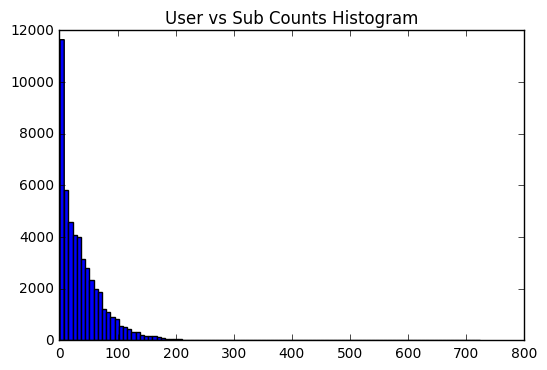

In [18]:
user_subs = df.groupby(['user'])['subreddit'].nunique()
plt.hist(user_subs.values, bins=100)
plt.title("User vs Sub Counts Histogram")
plt.show()

In [6]:
Counter(user_subs).most_common(5)

[(1, 2469), (2, 1829), (3, 1598), (4, 1325), (5, 1253)]

In [19]:
sub_users = df.groupby(['subreddit'])['user'].nunique()
data_tuple = pd.DataFrame([(sub,count) for sub,count in sub_users.items()],columns=["sub","user_count"])
sorted_df = data_tuple.sort_values(by='user_count',ascending=False)
sorted_df.head(25)

,sub,user_count
1902,AskReddit,31550
40726,pics,22042
33713,funny,21605
45848,todayilearned,20337
47709,worldnews,18391
33902,gaming,18363
46940,videos,18213
39285,news,16945
34158,gifs,16605
38801,movies,15005


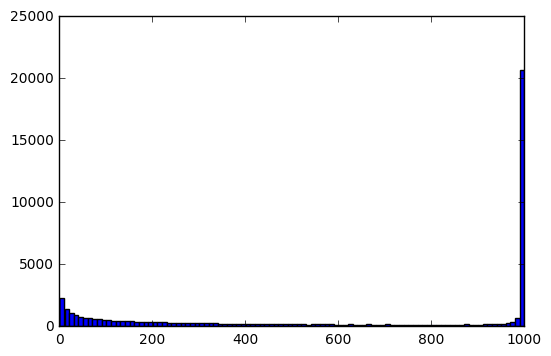

In [8]:
user_summary = df.groupby(by=['user'])['user']
plt.hist(user_summary.value_counts(), bins=100)
plt.show()

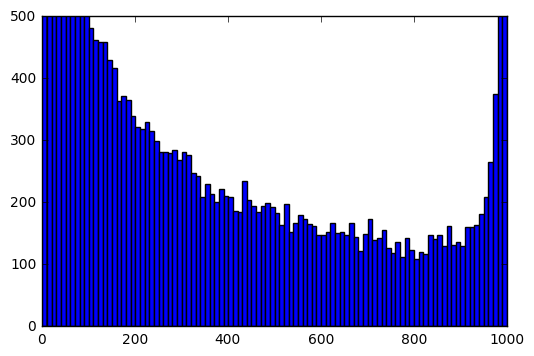

In [9]:
plt.hist(user_summary.value_counts(), bins=100)
axes = plt.gca()
axes.set_ylim([0,500])
plt.show()

In [10]:
users_vs_subs = []
current_user = reddit_data[0][0]
subs = []
interaction_count = 0
sub_discovery_time = []
usr_sub_discovery_time = [0]
user_subs_list = []
for i,comment in enumerate(reddit_data):
    if comment[0] != current_user:
        user_subs_list = [comment[1]]
        sub_discovery_time.append(usr_sub_discovery_time)
        usr_sub_discovery_time = []
        interaction_count = 0
        users_vs_subs.append(len(subs))
    elif comment[1] not in user_subs_list:
        usr_sub_discovery_time.append(interaction_count)
        interaction_count = 0
        user_subs_list.append(comment[1])
    if comment[1] not in subs:
        subs.append(comment[1])
    current_user = comment[0]
    if comment[1] != reddit_data[i-1][1]:
        interaction_count = interaction_count + 1

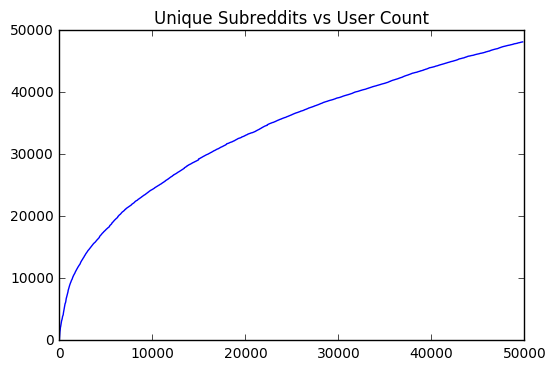

In [11]:
indexes = np.arange(len(users_vs_subs))
plt.plot(indexes,users_vs_subs)
plt.title("Unique Subreddits vs User Count")
plt.show()

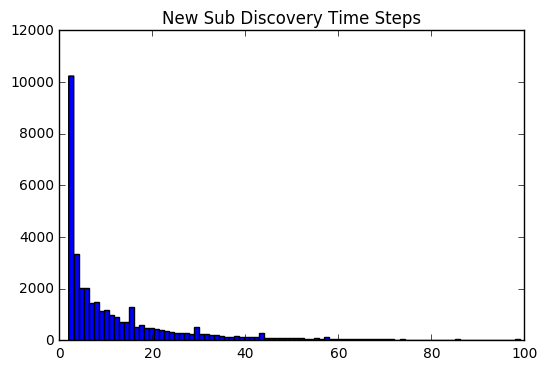

In [12]:
disc_times = [usr_dts[-1] for usr_dts in sub_discovery_time if usr_dts and usr_dts[-1] > 1 and  usr_dts[-1] <100]
plt.hist(disc_times , bins=90)
plt.title("New Sub Discovery Time Steps")
plt.show()

In [13]:
np.percentile(disc_times,95)

52.0

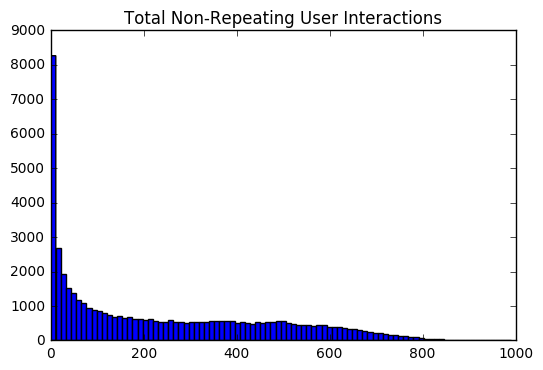

In [14]:
non_rep_interaction = [sum(usr_dts) for usr_dts in sub_discovery_time]
plt.hist(non_rep_interaction , bins=90)
plt.title("Total Non-Repeating User Interactions")
plt.show()

In [15]:
np.mean(non_rep_interaction)

240.39256389150989

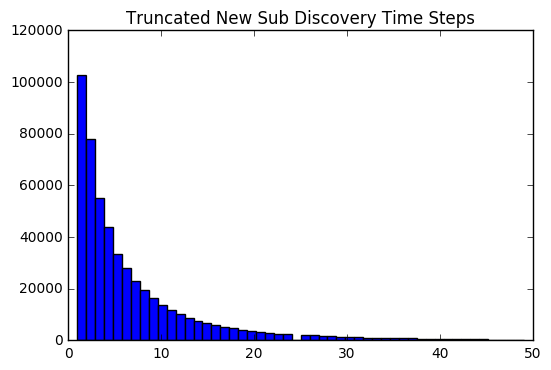

In [16]:
flt_disc_times = [dt for usr_dts in sub_discovery_time for dt in usr_dts[50:] if dt < 50]
plt.hist(flt_disc_times , bins=50)
plt.title("Truncated New Sub Discovery Time Steps")
plt.show()

In [17]:
np.mean(flt_disc_times)

6.826869319780017

<h2>Model Data Structure</h2>

To build the training dataset, the subreddit interaction sequence for each user can be ordered and then split into chunks representing different periods of Reddit interaction and discovery. From each chunk, we can randomly remove a single subreddit from the interaction as the "discovered" subreddit and use it as our training label for the interaction sequences. This formulation brings with it a hyperparameter that will require tuning, namely the sequence size of each chunk of user interaction periods. 

There are also a couple of design decisions needed that will create inherent assumptions in the model. This includes whether the labelled "discovered" subreddit should be randomly chosen from each interaction sequence, or should there be a more structured selection. The proposed model utilizes the distribution of subreddits existing in the dataset to weight the random selection of a subreddit as the sequence label, which gives a higher probability of selection to rarer subreddits. This will smoothen the distribution of training labels across the models vocabulary of subreddits in the dataset. Also, each users interaction sequence has been compressed to only represent the sequence of non-repeating subreddits, to eliminate the repeatative structure of users constantly commenting in a single subreddit, while providing information of the users habits in the reddit ecosystem more generally, allowing the model to distinguish broader patterns from the compressed sequences.

These subreddit sequence/subreddit label pairs are then passed to various RNN architectures (shallow and deep LSTM/GRU networks) with an exploration of hyperparamter optimization to select the optimal model for recommending new subreddits of interest to reddit users.

<h3>Model Sequencing</h3>

Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab
Building Vocab


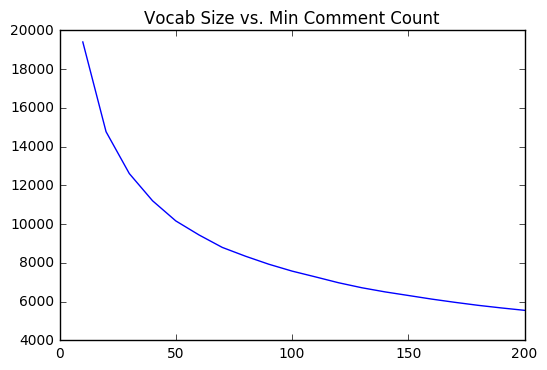

In [18]:
vocab_vs_min_thresh = []
for min_cnt in range(10,301,10):
    mdl = SubRecommender.SubRecommender('data/train_reddit_data.json',
                                sequence_chunk_size=5,min_seq_length=10,min_count_thresh=min_cnt)
    mdl.create_vocab()
    vocab_vs_min_thresh.append([min_cnt,mdl.vocab_size])
min_thresh,vocab_size = zip(*vocab_vs_min_thresh)
plt.plot(min_thresh,vocab_size)
plt.title("Vocab Size vs. Min Comment Count")
plt.show()

<h3>Model Training Data</h3>

In [ ]:
import SubRecommender
import json
from collections import Counter
import random
from tflearn.data_utils import to_categorical, pad_sequences

tst = SubRecommender.SubRecommender('data/train_reddit_data.json',
                                    sequence_chunk_size=15,min_seq_length=7,min_count_thresh=250,max_popularity=0.00075)
train_df= tst.load_train_df("data/training_sequences/5027_15_7_sequence_data.json")

Loading Training Data
Building Vocab
Data loaded from disk


In [2]:
train_df.head()

,seq_length,sub_label,sub_seqs
0,11,1957,"[263, 339, 1, 339, 263, 339, 195, 339, 339, 37..."
1,12,1318,"[203, 14, 1, 10, 27, 641, 4094, 339, 557, 1504..."
2,12,1623,"[5, 16, 5, 4968, 5, 1137, 5, 5, 813, 26, 31, 5]"
3,11,1488,"[89, 92, 237, 419, 39, 1030, 1965, 107, 1336, ..."
4,14,2041,"[101, 24, 1, 24, 16, 8, 47, 350, 1, 10, 24, 47..."


In [3]:
print ("Model Vocabulary Size = " + str(tst.vocab_size))
print ("Top Popular Filtered Subs = " + str(tst.vocab_size-len(tst.filtered_vocab)))
print ("Total Training Sequences = " + str(len(tst.training_sequences)))
print ("Training Label Coverage = " + str(round(len(set(tst.training_labels))/tst.vocab_size*100,0)))
print ("Average Samples per Sub = " + str(int(len(tst.training_labels)/tst.vocab_size)))

Model Vocabulary Size = 5027
Top Popular Filtered Subs = 219
Total Training Sequences = 766014
Training Label Coverage = 95.0
Average Samples per Sub = 152


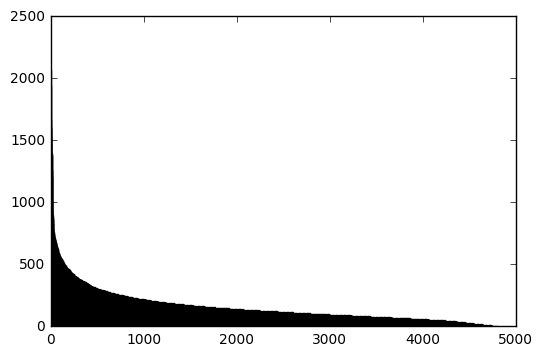

In [11]:
cnter = Counter(tst.training_labels).most_common(tst.vocab_size)
fig = plt.figure()
ax = plt.subplot(111)
_,y = zip(*cnter)
indexes = np.arange(len(cnter))
ax.bar(indexes, y)
plt.show()

<h3>Model Tuning</h3>

In [ ]:
learning_rate = random.uniform(0.00005,0.001)
n_units = random.choice([128])
dropout = random.uniform(0.4,0.9)
tst.train(num_epochs=10,chunks=2048,
          learning_rate=round(0.0008,5),n_units=128,dropout=round(0.23,2))

Training Step: 3254  | total loss: 7.40597 | time: 252.100s
| Adam | epoch: 002 | loss: 7.40597 -- iter: 181760/651111


In [4]:
tst.model.save("models/final_model.tfl")

INFO:tensorflow:C:\Users\macle\Desktop\UPC Masters\Semester 2\CI\SubRecommender\models\final_model.tfl is not in all_model_checkpoint_paths. Manually adding it.
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'list' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'list' object has no attribute 'name'


<h3>Model Validation</h3>

In [9]:
#from - https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [10]:
def recommendation_accuracy(user_data,model,clf,map_at=5, most_commom_limit=5):
    preds = []
    labels = []
    for usr,user_subs in user_data.items():
        user_seqs = tst.build_training_sequences(user_subs)
        training_sequences = [data[0] for data in user_seqs]
        training_labels = [data[1] for data in user_seqs]
        X_test = pad_sequences(training_sequences, maxlen=tst.sequence_chunk_size, value=0.,padding='post')
        if training_sequences:
            if model == 'rnn':
                sub_probs = clf.predict(X_test)
                recs = [probs.index(max(probs)) for probs in sub_probs]
            elif model == 'most_common':
                #clf is order counter of sub popularity
                recs = [clf[i][0] for i,seq in enumerate(training_sequences) if i <=most_commom_limit]
            elif model == 'random':
                lbl_set = list(set(tst.training_labels))
                recs = [random.choice(lbl_set) for seq in training_sequences]
            elif model == 'distributed_random':
                recs = [random.choice(tst.training_labels) for seq in training_sequences]
            top_x_recs,cnt = zip(*Counter(recs).most_common(map_at))
            preds.append(top_x_recs)
            labels.append(training_labels)       
    return mapk(labels,preds,map_at)

In [11]:
with open('data/test_user_comment_sequence_cache.json','r') as data_file:    
    user_seqs = json.load(data_file)

In [7]:
print(len(user_seqs))

1187


In [12]:
recommendation_accuracy(user_seqs,'rnn',tst.model,map_at=500)

0.041017332035297283

In [13]:
recommendation_accuracy(user_seqs,'random',None,map_at=500)

0.00027103204825117041

In [16]:
recommendation_accuracy(user_seqs,'most_common',cnter,map_at=500,most_commom_limit=500)

NameError: name 'cnter' is not defined

<h3>Embedding Visualization</h3>  
https://medium.com/@awjuliani/visualizing-deep-learning-with-t-sne-tutorial-and-video-e7c59ee4080c#.emchq1dkw

In [5]:
from sklearn.manifold import TSNE
embedding = tflearn.get_layer_variables_by_name("Embedding")[0]
finalWs = tst.model.get_weights(embedding)

In [6]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
lowDWeights = tsne.fit_transform(finalWs)

In [18]:
from bokeh.plotting import figure, show, output_notebook,output_file
from bokeh.models import ColumnDataSource, LabelSet


sparse_labels = [lbl if random.random() <=1 else '' for lbl in tst.vocab]
source = ColumnDataSource({'x':lowDWeights[:,0],'y':lowDWeights[:,1],'labels':sparse_labels})


TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)

p.scatter("x", "y", radius=0.1, fill_alpha=0.6,
          line_color=None,source=source)

labels = LabelSet(x="x", y="y", text="labels", y_offset=8,
                  text_font_size="10pt", text_color="#555555", text_align='center',
                 source=source)
p.add_layout(labels)

output_file("embedding.html")
output_notebook()
show(p)

Loading BokehJS ...